####**Linking Kaggle and Getting Embeddings**

In [ ]:
from google.colab import files
files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2020-06-08 11:53:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  14.1MB/s    in 1m 44s  

2020-06-08 11:55:28 (13.9 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [ ]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


####**Imports**

In [ ]:
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

TensorFlow 1.x selected.


####**F1 score function**

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

###**Sentiment Model**

####**Getting Data**

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 85% 69.0M/80.9M [00:00<00:00, 66.7MB/s]
100% 80.9M/80.9M [00:00<00:00, 111MB/s] 


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


####**Preprocessing Data and Preparing Embedding Weights**

In [ ]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1')
df.columns = ['target', 'id','date', 'flag', 'user', 'text']
df['target'] = df['target'].map({4:1, 0:0})
df = df.drop(['date', 'id', 'flag', 'user'], axis=1)
# print(df.head())
# print(df['target'].value_counts())

Maximum length of a sentence: 64


Text(0.5, 1.0, 'Distribution of lengths of all the sentences')

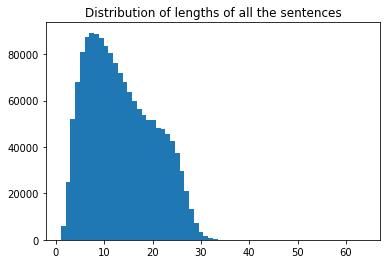

In [ ]:
temp1 = df['text'].apply(lambda x : len(x.split()))
print("Maximum length of a sentence:",max(temp1))
plt.hist(temp1, bins=max(temp1))
plt.title("Distribution of lengths of all the sentences")

Text(0.5, 1.0, 'Class Distribution')

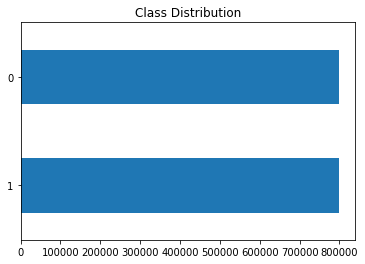

In [ ]:
df['target'].value_counts().plot(kind='barh')
plt.title("Class Distribution")

In [ ]:
X = np.array(df['text'])
y = np.array(df['target'])

y = y.reshape((y.shape[0],1))
X = X.squeeze()

m = X.shape[0]
perm = np.random.permutation(m)
X = X[perm]
y = y[perm,:]

X = X[:60000]
y = y[:60000,:]

X_test = X[:10000]
y_test = y[:10000,:]

X_val = X[10000:20000]
y_val = y[10000:20000,:]

X_train = X[20000:]
y_train = y[20000:,:]

In [ ]:
max_len = min(max(len(x.split()) for x in X_train), 20)
embedding_size = 300
embedding_file = 'crawl-300d-2M.vec'
print("max length:",max_len)

max length: 20


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(list(X_train))
X_train = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_val))
X_val = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_test))
X_test = np.array(pad_sequences(X, max_len))

print(y_train.shape, X_train.shape)
print(y_val.shape, X_val.shape)
print(y_test.shape, X_test.shape)

(40000, 1) (40000, 20)
(10000, 1) (10000, 20)
(10000, 1) (10000, 20)


In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab:", vocab_size)

vocab: 68672


In [ ]:
def get_indices(word, *arr):
    return word,np.asarray(arr, dtype=np.float32)

word_to_vec = dict(get_indices(*i.rstrip().rsplit()) for i in open(embedding_file))

embedding_matrix_S = np.zeros((vocab_size, embedding_size))

for word,i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None:
        embedding_matrix_S[i] = embedding_vector

####**Model**

In [ ]:
def sentiment():
    vocab_size=68672
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(vocab_size, 
                                        embedding_size, 
                                        input_length=max_len, 
                                        weights=[embedding_matrix_S], 
                                        trainable=True,
                                        name='Embedding_S'))
    
    model.add(tf.keras.layers.Conv1D(filters=50,
                                     kernel_size=5,
                                     activation='relu',
                                     name='conv1_S'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool1_S'))

    model.add(tf.keras.layers.Conv1D(filters=100,
                                     kernel_size=3,
                                     activation='relu',
                                     name='conv2_S'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool2_S'))
    model.add(tf.keras.layers.Flatten(name='flatten1_S'))

    model.add(tf.keras.layers.Dense(100, activation='relu', name='dense1_S'))
    model.add(tf.keras.layers.Dropout(0.75, name='dropout1_S'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_S'))

    return model

In [ ]:
batch_size = 32
epochs = 10
learning_rate = 1e-5

model = sentiment()
checkpointer = ModelCheckpoint(filepath = "/content/gdrive/My Drive/sentiment.hdf5", 
                               monitor='val_loss', 
                               verbose=1, 
                               save_best_only=True,
                               mode='min')

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', f1_m])

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    validation_data=(X_val,y_val))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
39936/40000 [============================>.] - ETA: 0s - loss: 0.6997 - acc: 0.5044 - f1_m: 0.4518
Epoch 00001: val_loss improved from inf to 0.68880, saving model to /content/gdrive/My Drive/sentiment.hdf5
40000/40000 [==============================] - 36s 896us/sample - loss: 0.6997 - acc: 0.5044 - f1_m: 0.4519 - val_loss: 0.6888 - val_acc: 0.5581 - val_f1_m: 0.4696
Epoch 2/10
39936/40000 [============================>.] - ETA: 0s - loss: 0.6892 - acc: 0.5403 - f1_m: 0.5138
Epoch 00002: val_loss improved from 0.68880 to 0.68194, saving model to /content/gdrive/My Drive/sentiment.hdf5
40000/40000 [==============================] - 31s 76

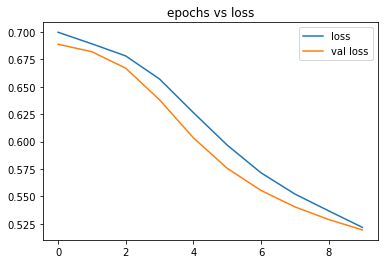

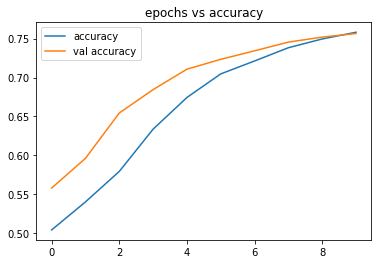

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()  

**Test Set Performance**

In [ ]:
model.load_weights('/content/gdrive/My Drive/sentiment.hdf5')
results = model.evaluate(X_test,
                         y_test,
                         batch_size=batch_size
                         )

10000/10000 [==============================] - 1s 88us/sample - loss: 0.5295 - acc: 0.7421 - f1_m: 0.7302


In [ ]:
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])
print ("F1 score on test set:", results[2])

Loss on test set: 0.5294501414299011
Accuracy on test set: 0.7421
F1 score on test set: 0.73015195


In [ ]:
def plot_roc(fpr,tpr,label= 'ROC curve'):
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import sklearn
import sklearn.metrics
y_score = model.predict(X_test, batch_size=1024)
y_preds = model.predict(X_test, batch_size=1024).round().astype(int)

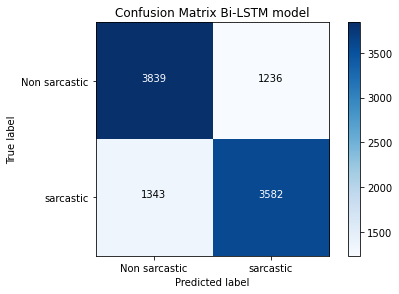

In [ ]:
import matplotlib.pyplot as plt   
import itertools
cm=sklearn.metrics.confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,classes=['Non sarcastic','sarcastic'],title='Confusion Matrix')

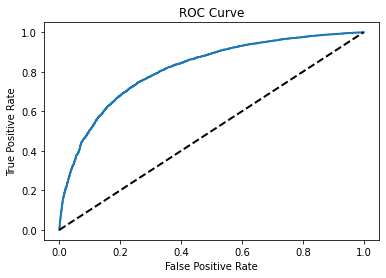

In [ ]:
fpr, tpr, t = sklearn.metrics.roc_curve(y_test, y_score)
plot_roc(fpr, tpr,label='ROC curve ')

In [ ]:
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_test,y_score))

Test accuracy score 0.7421
Precision=  0.7434620174346201
Recall=  0.7273096446700508
F1 score=  0.7352971364056246
auc=  0.8149366807531694


In [ ]:
S = sentiment()
S.load_weights('/content/gdrive/My Drive/sentiment.hdf5')

###**Sarcasm Model**

####**Getting Data**

In [ ]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 112MB/s]


In [ ]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


####**Preprocessing Data and Preparing Embedding Weights**

In [ ]:
df1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = pd.concat([df1[['headline', 'is_sarcastic']],df2[['headline', 'is_sarcastic']]], axis=0)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
temp1 = df1['headline'].apply(lambda x : len(x.split()))
print(max(temp1))
temp = df2['headline'].apply(lambda x : len(x.split()))
print(max(temp))

39
151


Text(0.5, 1.0, 'Distribution of lengths of sentences in dataset1')

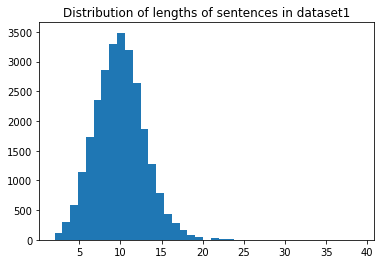

In [ ]:
plt.hist(temp1, bins=max(temp1))
plt.title("Distribution of lengths of sentences in dataset1")

Text(0.5, 1.0, 'Distribution of lengths of sentences in dataset2')

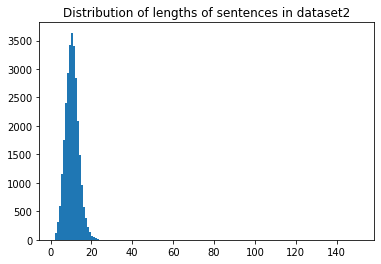

In [ ]:
plt.hist(temp, bins=max(temp))
plt.title("Distribution of lengths of sentences in dataset2")

Text(0.5, 1.0, 'Class Distribution')

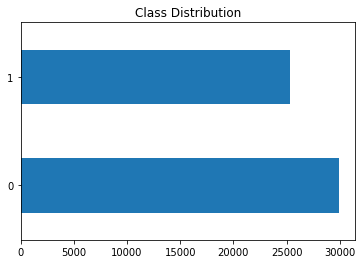

In [ ]:
df['is_sarcastic'].value_counts().plot(kind='barh')
plt.title("Class Distribution")

In [ ]:
# df = df.drop(['article_link'],axis=1)
# df['len'] = df['headline'].apply(lambda x : len(x.split()))

In [ ]:
X = np.array(df['headline'])
y = np.array(df['is_sarcastic'])

y = y.reshape((y.shape[0],1))
X = X.squeeze()
m = X.shape[0]
perm = np.random.permutation(m)
X = X[perm]
y = y[perm,:]

X_test = X[:10000]
y_test = y[:10000,:]

X_val = X[10000:20000]
y_val = y[10000:20000,:]

X_train = X[20000:]
y_train = y[20000:,:]

In [ ]:
max_len = min(max(len(x.split()) for x in X_train), 20) #25 when used lstm, 98% accuracy
embedding_size = 300
embedding_file = 'crawl-300d-2M.vec'
print("max length:",max_len)

max length: 20


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(list(X_train))
X_train = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_val))
X_val = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_test))
X_test = np.array(pad_sequences(X, max_len))

print(y_train.shape, X_train.shape)
print(y_val.shape, X_val.shape)
print(y_test.shape, X_test.shape)

(35328, 1) (35328, 20)
(10000, 1) (10000, 20)
(10000, 1) (10000, 20)


In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(vocab_size)

30885


In [ ]:
def get_indices(word, *arr):
    return word,np.asarray(arr, dtype=np.float32)

word_to_vec = dict(get_indices(*i.rstrip().rsplit()) for i in open(embedding_file))

embedding_matrix_B = np.zeros((vocab_size, embedding_size))

for word,i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None:
        embedding_matrix_B[i] = embedding_vector

####**CNN Model**

In [ ]:
def baseline():
    vocab_size=30885
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(vocab_size, 
                                        embedding_size, 
                                        input_length=max_len, 
                                        weights=[embedding_matrix_B], 
                                        trainable=True,
                                        name='Embedding_B'))
    
    model.add(tf.keras.layers.Conv1D(filters=50,
                                     kernel_size=5,
                                     activation='relu',
                                     name='conv1_B'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool1_B'))

    model.add(tf.keras.layers.Conv1D(filters=100,
                                     kernel_size=3,
                                     activation='relu',
                                     name='conv2_B'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool2_B'))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(100, activation='relu', name='dense1_B'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout1_B'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_B'))

    return model

In [ ]:
batch_size = 32
epochs = 10
learning_rate = 5e-5

model = baseline()
checkpointer = ModelCheckpoint(filepath = "/content/gdrive/My Drive/baseline.hdf5", 
                               monitor='val_loss', 
                               verbose=1,
                               save_best_only=True,
                               mode='min')

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', f1_m])

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    validation_data=(X_val,y_val))

Train on 35328 samples, validate on 10000 samples
Epoch 1/10
35296/35328 [============================>.] - ETA: 0s - loss: 0.5741 - acc: 0.6985 - f1_m: 0.6187
Epoch 00001: val_loss improved from inf to 0.40440, saving model to /content/gdrive/My Drive/baseline.hdf5
35328/35328 [==============================] - 16s 453us/sample - loss: 0.5740 - acc: 0.6986 - f1_m: 0.6189 - val_loss: 0.4044 - val_acc: 0.8271 - val_f1_m: 0.8139
Epoch 2/10
35200/35328 [============================>.] - ETA: 0s - loss: 0.3400 - acc: 0.8589 - f1_m: 0.8407
Epoch 00002: val_loss improved from 0.40440 to 0.29895, saving model to /content/gdrive/My Drive/baseline.hdf5
35328/35328 [==============================] - 17s 487us/sample - loss: 0.3398 - acc: 0.8590 - f1_m: 0.8408 - val_loss: 0.2990 - val_acc: 0.8780 - val_f1_m: 0.8613
Epoch 3/10
35296/35328 [============================>.] - ETA: 0s - loss: 0.2420 - acc: 0.9072 - f1_m: 0.8952
Epoch 00003: val_loss improved from 0.29895 to 0.25493, saving model to /c

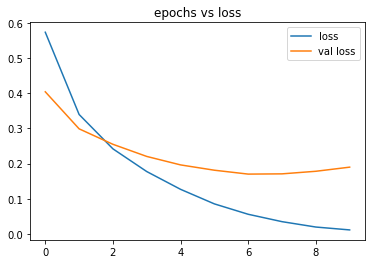

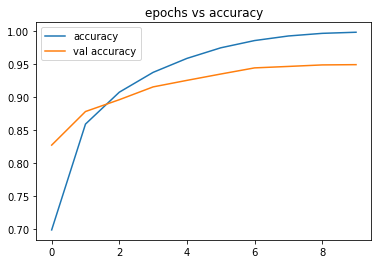

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()

**Test Set Performance**

In [ ]:
model.load_weights('/content/gdrive/My Drive/baseline.hdf5')
results = model.evaluate(X_test,
                         y_test,
                         batch_size=batch_size
                         )

10000/10000 [==============================] - 1s 86us/sample - loss: 0.1867 - acc: 0.9391 - f1_m: 0.9304


In [ ]:
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])
print ("F1 score on test set:", results[2])

Loss on test set: 0.18672041215598584
Accuracy on test set: 0.9391
F1 score on test set: 0.9303808


In [ ]:
y_score = model.predict(X_test, batch_size=1024)
y_preds = model.predict(X_test, batch_size=1024).round().astype(int)

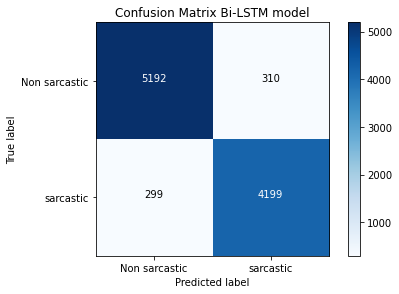

In [ ]:
cm=sklearn.metrics.confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,classes=['Non sarcastic','sarcastic'],title='Confusion Matrix')

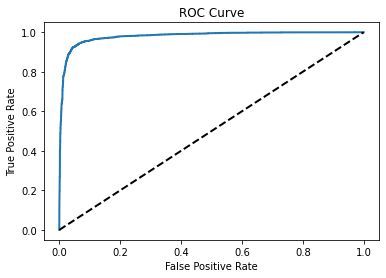

In [ ]:
fpr, tpr, t = sklearn.metrics.roc_curve(y_test, y_score)
plot_roc(fpr, tpr,label='ROC curve ')

In [ ]:
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_test,y_score))

Test accuracy score 0.9391
Precision=  0.9312486138833445
Recall=  0.9335260115606936
F1 score=  0.9323859220606194
auc=  0.9795343429019465


In [ ]:
B = baseline()
B.load_weights('/content/gdrive/My Drive/baseline.hdf5')

####**CNN-SVM Model**

In [ ]:
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

In [ ]:
m_temp = tf.keras.Model(inputs=B.input, outputs=B.get_layer('dropout1_B').output)
t = m_temp.predict(X_train)
arr = K.eval(t)

clf = svm.SVC(kernel='rbf', C=20, gamma=.1,probability=True)

train_sizes, train_scores, valid_scores = learning_curve(clf, arr, y_train.ravel())

clf.fit(arr, y_train.ravel())

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

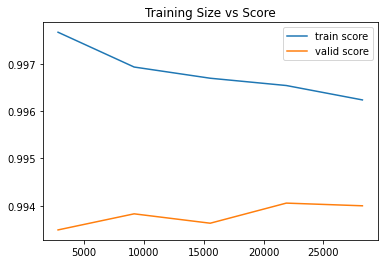

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='train score')
plt.plot(train_sizes, valid_scores_mean, label='valid score')
plt.legend()
plt.title("Training Size vs Score")
plt.show()

In [ ]:
m_temp = tf.keras.Model(inputs=B.input, outputs=B.get_layer('dense1_B').output)
tt = m_temp.predict(X_test)
tt = K.eval(tt)
ans = clf.predict(tt)

tt = m_temp.predict(X_train)
tt = K.eval(tt)
trn = clf.predict(tt)

tt = m_temp.predict(X_val)
tt = K.eval(tt)
val = clf.predict(tt)
print("Train Acc:", accuracy_score(y_train.ravel(), trn))
print("Val Acc:", accuracy_score(y_val.ravel(), val))
print("Test Acc:", accuracy_score(y_test.ravel(), ans))

Train Acc: 0.99609375
Val Acc: 0.9468
Test Acc: 0.9426


In [ ]:
m_temp = tf.keras.Model(inputs=B.input, outputs=B.get_layer('dense1_B').output)
tt = m_temp.predict(X_test)
tt = K.eval(tt)
y_score = clf.predict_proba(tt)[:, 1]
y_preds = clf.predict(tt).round().astype(int)

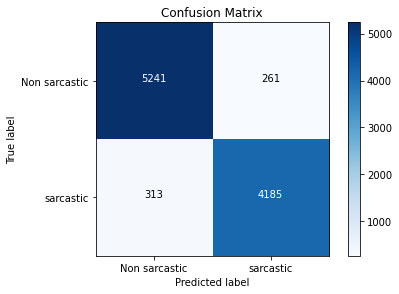

In [ ]:
cm=sklearn.metrics.confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,classes=['Non sarcastic','sarcastic'],title='Confusion Matrix')

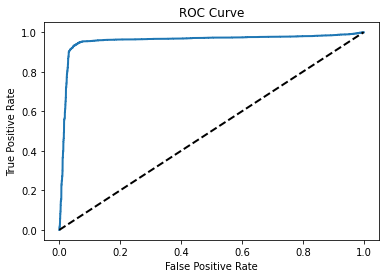

In [ ]:
fpr, tpr, t = sklearn.metrics.roc_curve(y_test, y_score)
plot_roc(fpr, tpr,label='ROC curve ')

In [ ]:
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_test,y_score))

Test accuracy score 0.9426
Precision=  0.9412955465587044
Recall=  0.9304135171187194
F1 score=  0.9358228980322004
auc=  0.9558696793065589


###**Model Combination**

####**Baseline with Sentiment**

In [ ]:
sentiment_model = tf.keras.Model(inputs=S.input, outputs=S.get_layer('dropout1_S').output)
baseline_model = tf.keras.Model(inputs=B.input, outputs=B.get_layer('dropout1_B').output)

sentiment_model.trainable = True
baseline_model.trainable = True

In [ ]:
def combined():
    ip = tf.keras.Input(shape=(max_len,))

    x1 = sentiment_model(ip)
    x2 = baseline_model(ip)
    z = tf.keras.layers.concatenate([x2,x1], axis=1)
    z = tf.keras.layers.Flatten(name='flatten1_C')(z)
    z = tf.keras.layers.Dropout(0.65, name='dropout1_C')(z)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(z)

    model = tf.keras.Model(inputs=ip, outputs=out)
    
    return model

In [ ]:
batch_size = 32
epochs = 10
learning_rate = 1e-5

model = combined()
checkpointer = ModelCheckpoint(filepath = "/content/gdrive/My Drive/combined.hdf5", 
                               monitor='val_loss', 
                               verbose=1,
                               save_best_only=True,
                               mode='min')

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', f1_m])

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    validation_data=(X_val,y_val))

Train on 35328 samples, validate on 10000 samples
Epoch 1/10
35296/35328 [============================>.] - ETA: 0s - loss: 0.5679 - acc: 0.7087 - f1_m: 0.6788
Epoch 00001: val_loss improved from inf to 0.30610, saving model to /content/gdrive/My Drive/combined.hdf5
35328/35328 [==============================] - 39s 1ms/sample - loss: 0.5677 - acc: 0.7088 - f1_m: 0.6790 - val_loss: 0.3061 - val_acc: 0.9379 - val_f1_m: 0.9317
Epoch 2/10
35296/35328 [============================>.] - ETA: 0s - loss: 0.2752 - acc: 0.9085 - f1_m: 0.8965
Epoch 00002: val_loss improved from 0.30610 to 0.22219, saving model to /content/gdrive/My Drive/combined.hdf5
35328/35328 [==============================] - 40s 1ms/sample - loss: 0.2752 - acc: 0.9085 - f1_m: 0.8966 - val_loss: 0.2222 - val_acc: 0.9390 - val_f1_m: 0.9309
Epoch 3/10
35296/35328 [============================>.] - ETA: 0s - loss: 0.1996 - acc: 0.9451 - f1_m: 0.9380
Epoch 00003: val_loss improved from 0.22219 to 0.19118, saving model to /conte

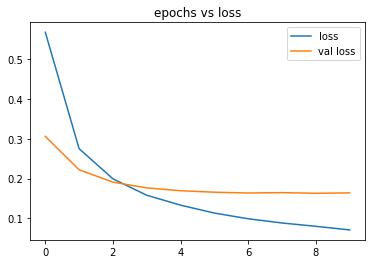

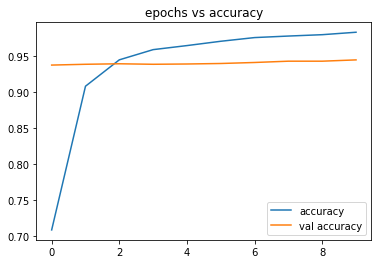

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()  

**Test Set Performance**

In [ ]:
model.load_weights('/content/gdrive/My Drive/combined.hdf5')
results = model.evaluate(X_test,
                         y_test,
                         batch_size=batch_size
                         )

10000/10000 [==============================] - 1s 118us/sample - loss: 0.1765 - acc: 0.9404 - f1_m: 0.9317


In [ ]:
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])
print ("F1 score on test set:", results[2])

Loss on test set: 0.17649455544054507
Accuracy on test set: 0.9404
F1 score on test set: 0.9316517


In [ ]:
y_score = model.predict(X_test, batch_size=1024)
y_preds = model.predict(X_test, batch_size=1024).round().astype(int)

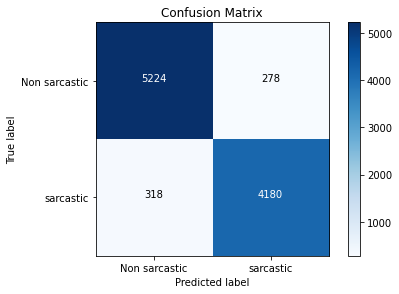

In [ ]:
cm=sklearn.metrics.confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,classes=['Non sarcastic','sarcastic'],title='Confusion Matrix')

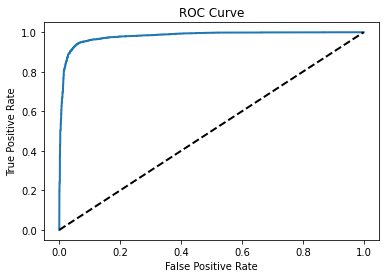

In [ ]:
fpr, tpr, t = sklearn.metrics.roc_curve(y_test, y_score)
plot_roc(fpr, tpr,label='ROC curve ')

In [ ]:
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_test,y_score))

Test accuracy score 0.9404
Precision=  0.9376401973979362
Recall=  0.9293019119608715
F1 score=  0.9334524341223761
auc=  0.9802632099989026


####**Combined SVM**

In [ ]:
m_temp = tf.keras.Model(inputs=model.input, outputs=model.get_layer('dropout1_C').output)
t = m_temp.predict(X_train)
arr = K.eval(t)

clf = svm.SVC(kernel='rbf', C=25, gamma=.1,probability=True)

train_sizes, train_scores, valid_scores = learning_curve(clf, arr, y_train.ravel())

clf.fit(arr, y_train.ravel())

SVC(C=25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

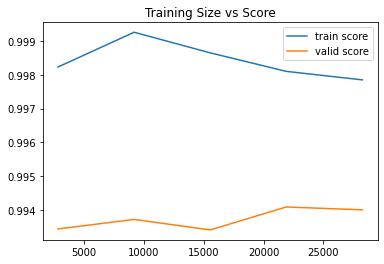

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='train score')
plt.plot(train_sizes, valid_scores_mean, label='valid score')
plt.legend()
plt.title("Training Size vs Score")
plt.show()

In [ ]:
m_temp = tf.keras.Model(inputs=model.input, outputs=model.get_layer('flatten1_C').output)
tt = m_temp.predict(X_test)
tt = K.eval(tt)
ans = clf.predict(tt)

tt = m_temp.predict(X_train)
tt = K.eval(tt)
trn = clf.predict(tt)

tt = m_temp.predict(X_val)
tt = K.eval(tt)
val = clf.predict(tt)
print("Train Acc:", accuracy_score(y_train.ravel(), trn))
print("Val Acc:", accuracy_score(y_val.ravel(), val))
print("Test Acc:", accuracy_score(y_test.ravel(), ans))

Train Acc: 0.9976222826086957
Val Acc: 0.949
Test Acc: 0.9446


In [ ]:
m_temp = tf.keras.Model(inputs=model.input, outputs=model.get_layer('flatten1_C').output)
tt = m_temp.predict(X_test)
tt = K.eval(tt)
y_score = clf.predict_proba(tt)[:, 1]
y_preds = clf.predict(tt).round().astype(int)

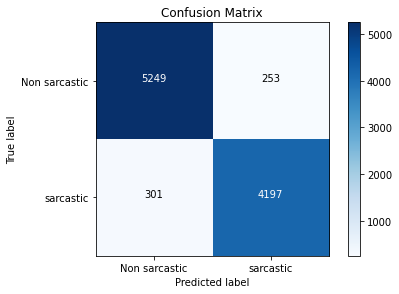

In [ ]:
cm=sklearn.metrics.confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,classes=['Non sarcastic','sarcastic'],title='Confusion Matrix')

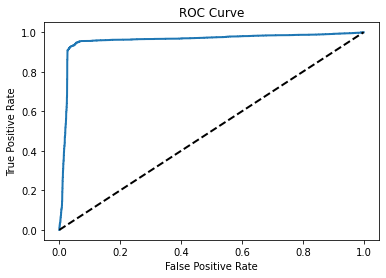

In [ ]:
fpr, tpr, t = sklearn.metrics.roc_curve(y_test, y_score)
plot_roc(fpr, tpr,label='ROC curve ')

In [ ]:
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_test,y_score))

Test accuracy score 0.9446
Precision=  0.9431460674157304
Recall=  0.9330813694975545
F1 score=  0.9380867232901208
auc=  0.9568268073099737
